### pipeline with dimension reduction, gridsearch pipeline

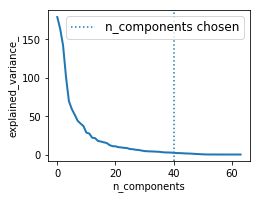

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# Plot the PCA spectrum
pca.fit(X_digits)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_digits, y_digits)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

### pipeline with imputing missing values (numeric), xval pipeline

In [2]:
import numpy as np

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

rng = np.random.RandomState(0)

dataset = load_boston()
X_full, y_full = dataset.data, dataset.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

# Estimate the score on the entire dataset, with no missing values
estimator = RandomForestRegressor(random_state=0, n_estimators=100)
score = cross_val_score(estimator, X_full, y_full).mean()
print("Score with the entire dataset = %.2f" % score)

# Add missing values in 75% of the lines
missing_rate = 0.75
n_missing_samples = int(np.floor(n_samples * missing_rate))
missing_samples = np.hstack((np.zeros(n_samples - n_missing_samples,
                                      dtype=np.bool),
                             np.ones(n_missing_samples,
                                     dtype=np.bool)))
rng.shuffle(missing_samples)
missing_features = rng.randint(0, n_features, n_missing_samples)

# Estimate the score without the lines containing missing values
X_filtered = X_full[~missing_samples, :]
y_filtered = y_full[~missing_samples]
estimator = RandomForestRegressor(random_state=0, n_estimators=100)
score = cross_val_score(estimator, X_filtered, y_filtered).mean()
print("Score without the samples containing missing values = %.2f" % score)

# Estimate the score after imputation of the missing values
X_missing = X_full.copy()
X_missing[np.where(missing_samples)[0], missing_features] = 0
y_missing = y_full.copy()
estimator = Pipeline([("imputer", Imputer(missing_values=0,
                                          strategy="mean",
                                          axis=0)),
                      ("forest", RandomForestRegressor(random_state=0,
                                                       n_estimators=100))])
score = cross_val_score(estimator, X_missing, y_missing).mean()
print("Score after imputation of the missing values = %.2f" % score)

Score with the entire dataset = 0.56
Score without the samples containing missing values = 0.48
Score after imputation of the missing values = 0.57


### pipeline with feature selection, xval pipeline

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 0  7  8 15 16 23 24 31 32 39 40 47 48 56 63] are constant.
  UserWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 0  8 15 16 23 31 32 39 40 48 56] are constant.
  UserWarning)


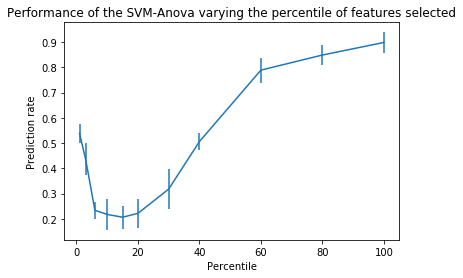

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets, feature_selection
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# #############################################################################
# Import some data to play with
digits = datasets.load_digits()
y = digits.target
# Throw away data, to be in the curse of dimension settings
y = y[:200]
X = digits.data[:200]
n_samples = len(y)
X = X.reshape((n_samples, -1))
# add 200 non-informative features
X = np.hstack((X, 2 * np.random.random((n_samples, 200))))

# #############################################################################
# Create a feature-selection transform and an instance of SVM that we
# combine together to have an full-blown estimator

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, X, y, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

### pipeline with feature combination, gridsearch pipeline

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

iris = load_iris()

X, y = iris.data, iris.target

# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1, score=0.960784313725, total=   0.0s
[CV] features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1, score=0.901960784314, total=   0.0s
[CV] features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1, score=0.979166666667, total=   0.0s
[CV] features__pca__n_components=1, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, features__univ_select__k=1, score=0.941176470588, total=   0.0s
[CV] features__pca__n_components=1, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, features__univ_select__k=1, score=0.921568627451, total=   0.0s
[C

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV]  features__pca__n_components=1, svm__C=0.1, features__univ_select__k=2, score=0.979166666667, total=   0.0s
[CV] features__pca__n_components=1, svm__C=1, features__univ_select__k=2 
[CV]  features__pca__n_components=1, svm__C=1, features__univ_select__k=2, score=0.960784313725, total=   0.0s
[CV] features__pca__n_components=1, svm__C=1, features__univ_select__k=2 
[CV]  features__pca__n_components=1, svm__C=1, features__univ_select__k=2, score=0.921568627451, total=   0.0s
[CV] features__pca__n_components=1, svm__C=1, features__univ_select__k=2 
[CV]  features__pca__n_components=1, svm__C=1, features__univ_select__k=2, score=1.0, total=   0.0s
[CV] features__pca__n_components=1, svm__C=10, features__univ_select__k=2 
[CV]  features__pca__n_components=1, svm__C=10, features__univ_select__k=2, score=0.980392156863, total=   0.0s
[CV] features__pca__n_components=1, svm__C=10, features__univ_select__k=2 
[CV]  features__pca__n_components=1, svm__C=10, features__univ_select__k=2, score

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.7s finished


### dim reduction in pipeline, gridsearch pipeline combine with diff feat selection methods

In [5]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

print(__doc__)

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
digits = load_digits()
grid.fit(digits.data, digits.target)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

Automatically created module for IPython interactive environment


In [6]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

# Create a temporary folder to store the transformers of the pipeline
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)
cached_pipe = Pipeline([('reduce_dim', PCA()),
                        ('classify', LinearSVC())],
                       memory=memory)

# This time, a cached pipeline will be used within the grid search
grid = GridSearchCV(cached_pipe, cv=3, n_jobs=1, param_grid=param_grid)
digits = load_digits()
grid.fit(digits.data, digits.target)

# Delete the temporary cache before exiting
rmtree(cachedir)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
None, array([[ 0., ...,  0.],
       ..., 
       [ 0., ...,  0.]]), array([0, ..., 8]))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PCA(copy=True, iterated_power=7, n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 
None, array([[ 0., ...,  0.],
       ..., 
       [ 0., ...,  0.]]), array([0, ..., 8]))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_

________________________________________________fit_transform_one - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from c:\users\liuleo\appdata\local\temp\tmpvlreqm\joblib\sklearn\pipeline\_fit_transform_one\0fd89445b22c1f9a6464e5f1cea5c91c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from c:\users\liuleo\appdata\local\temp\tmpvlreqm\joblib\sklearn\pipeline\_fit_transform_one\0321d64df59bc8a22af826fe495d67c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from c:\users\liuleo\appdata\local\temp\tmpvlreqm\joblib\sklearn\pipeline\_fit_transform_one\a4a8d2815169086b4cd7d66c1cf87e01
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from c:\users\liuleo\appdata\local\temp\tmpvlreqm\joblib\sklearn\pipeline\_fit_transfo

[Memory]    0.0s, 0.0min: Loading _fit_transform_one from c:\users\liuleo\appdata\local\temp\tmpvlreqm\joblib\sklearn\pipeline\_fit_transform_one\ced9ad093e673fe5d72c9e270584170a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from c:\users\liuleo\appdata\local\temp\tmpvlreqm\joblib\sklearn\pipeline\_fit_transform_one\ba4c8dd9494c503fce088b3c795bc64f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from c:\users\liuleo\appdata\local\temp\tmpvlreqm\joblib\sklearn\pipeline\_fit_transform_one\705525dc2ec95a0d5de61440176dc212
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from c:\users\liuleo\appdata\local\temp\tmpvlreqm\joblib\sklearn\pipeline\_fit_transform_one\b0cfbd03085aa8a3b0205906db884d45
___________________________________fit_tr

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=8, score_func=<function chi2 at 0x000000000950E048>), None, array([[ 0., ...,  0.],
       ..., 
       [ 0., ...,  0.]]), array([0, ..., 8]))
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=8, score_func=<function chi2 at 0x000000000950E048>), None, array([[ 0., ...,  0.],
       ..., 
       [ 0., ...,  0.]]), array([0, ..., 4]))
________________________________________________fit_transform_one - 0.0s, 0.0min
[Memory]    0.0s, 0.0min: Loading _fit_transform_one from c:\users\liuleo\appdata\local\temp\tmpvlreqm\joblib\sklearn\pipeline\_fit_transform_one\0666ccf0349dc27215cb030d17e85487
_________________________________

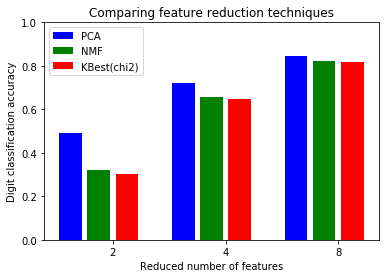

In [7]:
plt.show()

### category encoding in pipeline, grid search the category encoding method

In [9]:
from __future__ import print_function

from sklearn import datasets
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from category_encoders.basen import BaseNEncoder
from examples.source_data.loaders import get_mushroom_data
from sklearn.linear_model import LogisticRegression

print(__doc__)

# first we get data from the mushroom dataset
X, y, _ = get_mushroom_data()
X = X.values  # use numpy array not dataframe here
n_samples = X.shape[0]

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# create a pipeline
ppl = Pipeline([
    ('enc', BaseNEncoder(base=2, return_df=False, verbose=True)),
    ('clf', LogisticRegression())
])


# Set the parameters by cross-validation
tuned_parameters = {
    'enc__base': [1, 2, 3, 4, 5, 6]
}

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s\n" % score)
    clf = GridSearchCV(ppl, tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:\n")
    print(clf.best_params_)
    print("\nGrid scores on development set:\n")
    for mean, std, params in clf.grid_scores_:
        print("%s (+/-%s) for %s" % (mean, std * 2, params))

    print("\nDetailed classification report:\n")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n")
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Automatically created module for IPython interactive environment


IOError: File source_data/mushrooms/agaricus-lepiota.csv does not exist